### 本文件构造诸多特征，包括用户历史行为特征和问题历史特征，embedding距离距离，协同过滤计算topics相似度，话题相似度特征，等等

In [2]:
import os
import pandas as pd
import numpy as np
import random
from math import ceil
from time import time
import torch
from lightgbm import LGBMClassifier, Dataset

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In [5]:
dataDir= '../data'

In [6]:
tp_df = pd.read_csv(os.path.join(dataDir, 'topic_vectors_64d.txt'), sep= '\t', nrows= 500, header= None)

In [7]:
print('loading data...')
invite_df = pd.read_csv(os.path.join(dataDir, 'invite_info_1118.csv'),
                        # usecols= ['question_id', 'user_id', 'create_day', 'is_answer'],
                        sep='\t',
                        # nrows= 10000,
                        index_col=0,
                        )
test_df = pd.read_csv(os.path.join(dataDir, 'test_info_1118.csv'),
                        # usecols= ['question_id', 'user_id', 'create_day', 'is_answer'],
                        sep='\t',
                        # nrows= 10000,
                        index_col=0,
                        )
user_df = pd.read_csv(os.path.join(dataDir, 'member_info_1106.csv'),
                      # usecols= ['user_id', 'gender', 'visit_freq', 'binary_A',
                      #        'binary_B', 'binary_C', 'binary_D', 'binary_E',
                      #        'category_A',
                      #        'category_B',
                      #        'category_C',
                      #        'category_D', 'category_E', 'salt_value', 'follow_topics_mp', 'interest_topics'],
                      index_col='user_id',
                      sep='\t',
                      # nrows= 10000,
                      )
user_follow_topics_mp = np.load(os.path.join(dataDir, 'user_follow_topics_mp.npy'))
user_interest_topics_wp = np.load(os.path.join(dataDir, 'interest_topic_wp.npy'))
user_array_dict = {'follow_topics_mp': user_follow_topics_mp,
                   'interest_topics_wp': user_interest_topics_wp
                   }
quest_df = pd.read_csv(os.path.join(dataDir, 'question_info_1111.csv'),
                       # usecols= ['question_id', 'title_SW', 'title_W', 'question_topics_mp', 'title_W_ind', 'create_day',
                       #           'has_describe', 'describe_length'],
                       index_col='question_id',
                       sep='\t',
                       # nrows= 10000
                       )
question_topics_mp = np.load(os.path.join(dataDir, 'question_topics_mp.npy'))
# np.save(os.path.join(dataDir, 'question_topics_mp.npy'), question_topics_mp)
quest_array_dict = {'question_topics_mp': question_topics_mp}

ans_df= pd.read_csv(os.path.join(dataDir, 'answer_info_1106.csv'), sep= '\t', index_col= 'answer_id')

topics_embed = np.load(os.path.join(dataDir, 'topic_array.npy'))

loading data...


/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
invite_df_cat = pd.concat([invite_df, test_df], axis= 0)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
invite_df_cat.columns

Index(['answer_id', 'create_day', 'create_hour', 'create_time',
       'create_weekday', 'days_since_last_ans', 'days_since_last_ans_scaled',
       'hist_create_hour_mean', 'hist_length', 'hist_num_collect_sum',
       'hist_num_comment_sum', 'hist_num_report_sum', 'hist_num_thanks_sum',
       'hist_num_useless_sum', 'hist_num_zan_sum', 'hist_word_count_sum',
       'is_answer', 'is_test', 'question_id', 'user_id'],
      dtype='object')

In [10]:
invite_df_cat.drop(columns = [ 'days_since_last_ans', 'days_since_last_ans_scaled',
       'hist_create_hour_mean', 'hist_length', 'hist_num_collect_sum',
       'hist_num_comment_sum', 'hist_num_report_sum', 'hist_num_thanks_sum',
       'hist_num_useless_sum', 'hist_num_zan_sum', 'hist_word_count_sum'], inplace= True)

In [11]:
invite_df_cat.head(20)

,answer_id,create_day,create_hour,create_time,create_weekday,is_answer,is_test,question_id,user_id
8239342,A1260717197,3842,16,D3842-H16,6,1,0,Q2574396618,M1000000382
5345128,NaN,3844,15,D3844-H15,1,0,0,Q2557202265,M1000000382
9167807,NaN,3846,21,D3846-H21,3,0,0,Q3910864809,M1000000382
3507059,NaN,3860,21,D3860-H21,3,0,0,Q1282394327,M1000000382
736806,NaN,3861,17,D3861-H17,4,0,0,Q4251023727,M1000000382
1266509,NaN,3862,20,D3862-H20,5,0,0,Q2418257178,M1000000382
2562710,NaN,3865,18,D3865-H18,1,0,0,Q4038278259,M1000000382
4155269,NaN,3866,21,D3866-H21,2,0,0,Q3739876694,M1000000382
3338794,NaN,3846,19,D3846-H19,3,0,0,Q390050321,M1000000983
6296086,A2323857635,3847,20,D3847-H20,4,1,0,Q2611259517,M1000000983


In [12]:
print(invite_df_cat['create_day'].min(), invite_df_cat['create_day'].max(), invite_df['create_day'].min(), invite_df['create_day'].max(), test_df['create_day'].min(), test_df['create_day'].max())

3838 3874 3838 3867 3868 3874


#### 一些分析

In [13]:
invite_day_count = invite_df_cat['create_day'].value_counts()
ans_day_count = invite_df_cat.loc[invite_df_cat['is_answer'] == 1]['create_day'].value_counts()

In [14]:
invite_day_count = invite_day_count.sort_index()
ans_day_count = ans_day_count.sort_index()

ans_invite_count_df = pd.concat([invite_day_count.rename('invite_count'), ans_day_count.rename('ans_count')], axis= 1)

ans_invite_count_df.head()

ans_invite_count_df['accept_ratio'] = ans_invite_count_df['ans_count'] / ans_invite_count_df['invite_count']

<IPython.core.display.Javascript object>


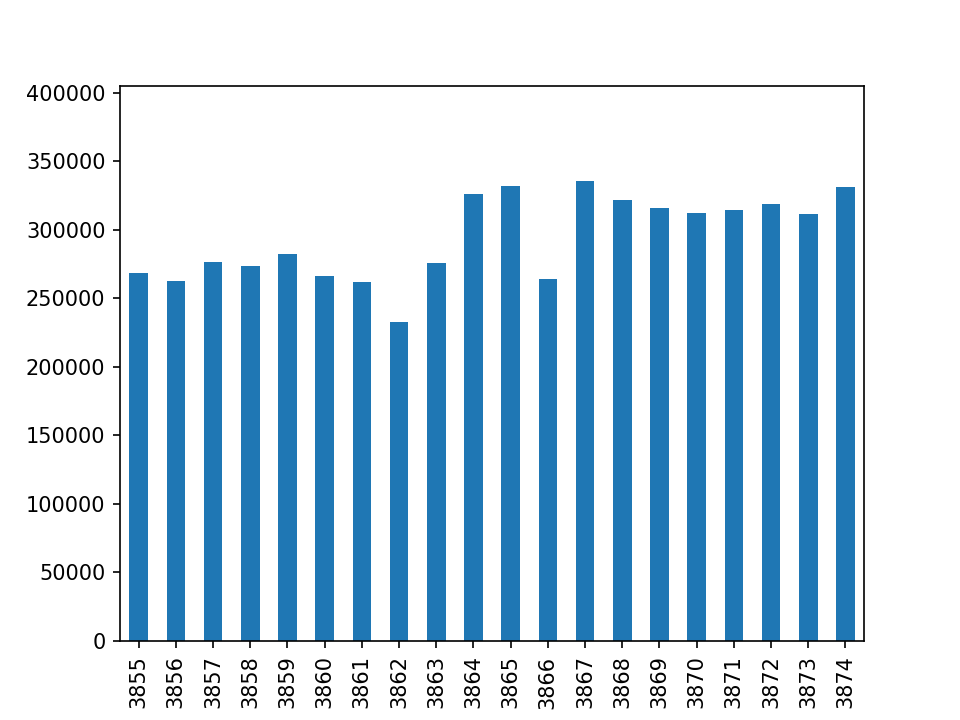

In [15]:
ans_invite_count_df['accept_ratio'].sort_index().plot.bar()

#### 用户回答意愿有月份周期规律？？？

In [16]:
ans_day_count.plot.bar()

In [17]:
invite_day_count.plot.bar()

In [18]:
test_quest_create_day = test_df['question_id'].map(quest_df['create_day'])

print(test_quest_create_day.min(), test_quest_create_day.max())

813 3874


In [ ]:
train_quest_create_day = train_df['question_id'].map(quest_df['create_day'])

train_quest_create_day.value_counts().sort_values().iloc[-20:].plot.bar()

<IPython.core.display.Javascript object>


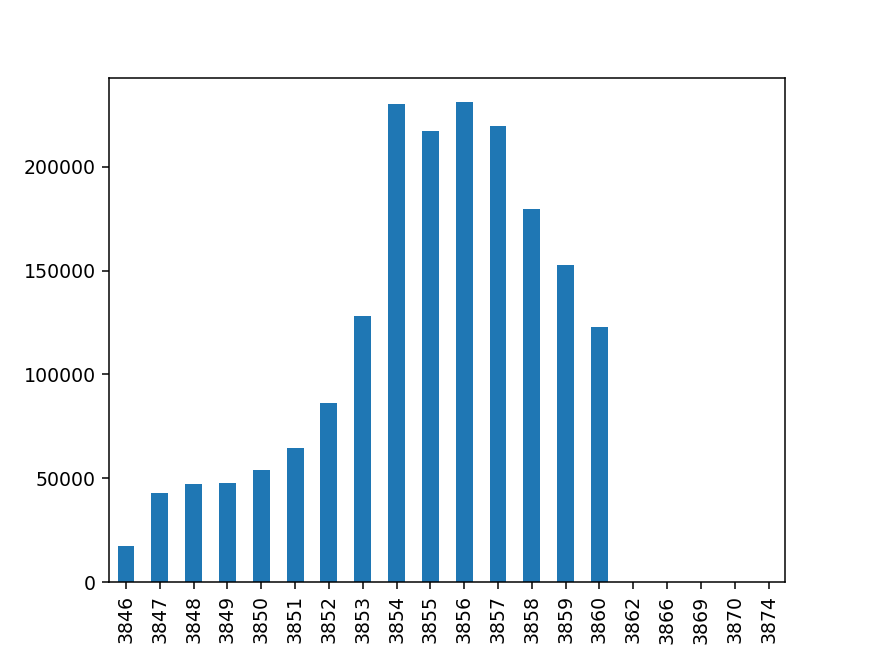

In [286]:
train_quest_create_day.value_counts().sort_index().iloc[-20:].plot.bar()

#### 预测集里的邀请问题大多是新创建的

In [19]:
test_quest_create_day.value_counts().sort_index().iloc[-20:].plot.bar()

In [20]:
test_quest_create_day_count= test_quest_create_day.value_counts()
print(test_quest_create_day_count.loc[test_quest_create_day_count.index < 3868].sum() / test_quest_create_day_count.sum())

0.37282765881597607


#### 37%的问题是老问题， 60%的问题是新问题，由于问题大多是新创建的，问题的历史回答就没有多大意义

#### 用户的历史回答 和 基于内容的特征 应该作用更大

In [76]:
def create_invite_df_with_user_history(pred_day_range, hist_day_range, configStr):
    train_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] >= pred_day_range[0], invite_df_cat['create_day'] <= pred_day_range[1])]

    hist_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] <= hist_day_range[1], invite_df_cat['create_day'] >= hist_day_range[0])]

    hist_df.head()

    hist_quest_sr= hist_df.loc[hist_df['is_answer'] == 1].groupby(by= 'user_id')['question_id'].apply(list)

    hist_quest_decline_sr= hist_df.loc[hist_df['is_answer'] == 0].groupby(by= 'user_id')['question_id'].apply(list)

    hist_invite_count = hist_df.groupby('user_id')['question_id'].count()
    
    train_df['user_hist_invite_count'] = train_df['user_id'].map(hist_invite_count)
    train_df['user_hist_invite_count'].fillna(0, inplace= True)
    train_df['user_hist_answer_count'] = train_df['user_id'].map(hist_quest_sr.apply(len))
    train_df['user_hist_answer_count'].fillna(0, inplace= True)
    train_df['user_hist_decline_count'] = train_df['user_id'].map(hist_quest_decline_sr.apply(len))
    train_df['user_hist_decline_count'].fillna(0, inplace= True)

    train_df['user_hist_quest'] = train_df['user_id'].map(hist_quest_sr.apply(lambda l: ','.join(l)))
    train_df['user_hist_quest'].fillna('', inplace= True)

    train_df['user_hist_quest_decline'] = train_df['user_id'].map(hist_quest_decline_sr.apply(lambda l: ','.join(l)))
    train_df['user_hist_quest_decline'].fillna('', inplace= True)

    hist_ans_sr =  hist_df.loc[hist_df['is_answer'] == 1].groupby(by= 'user_id')['answer_id'].apply(list)

    train_df['hist_ans'] = train_df['user_id'].map(hist_ans_sr.apply(lambda l: ','.join(l)))
    train_df['hist_ans'].fillna('', inplace= True)

    def quest2topics(quest_ls):
        topics_str_list = quest_df['question_topics'][quest_ls].to_list()
        topics_str = ','.join(topics_str_list)
        return topics_str

    train_df['user_hist_quest_topics'] = train_df['user_id'].map(hist_quest_sr.apply(quest2topics))
    train_df['user_hist_quest_topics'].fillna('', inplace= True)

    train_df['user_hist_quest_decline_topics'] = train_df['user_id'].map(hist_quest_decline_sr.apply(quest2topics))
    train_df['user_hist_quest_decline_topics'].fillna('', inplace= True)

    train_df['quest_topics'] = train_df['question_id'].map(quest_df['question_topics'])

    train_df['user_interest_topics'] = train_df['user_id'].map(user_df['interest_topics'])
    train_df['user_follow_topics'] = train_df['user_id'].map(user_df['follow_topics'])


    last_ans_day_sr= hist_df.loc[hist_df['is_answer'] == 1].groupby(by= 'user_id')['create_day'].max()

    train_df['last_ans_day'] = train_df['user_id'].map(last_ans_day_sr)

    train_df['last_ans_day'].fillna(hist_day_range[0] - 5, inplace= True)

    train_df['days_since_last_ans'] = train_df['create_day'] - train_df['last_ans_day'] 
    train_df.to_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t')

In [91]:
from multiprocessing import Pool
from time import time
from math import isnan
from functools import partial
def intersect_count(row, attr_1, attr_2):
        str_1= row[attr_1]
        str_2= row[attr_2]
        if isinstance(str_1, str) and isinstance(str_2, str):
            set_1 = set(str_1.split(','))
            set_2 = set(str_2.split(','))
            return len(set_1 & set_2)
        else:
            return 0

    

cal_quest_hist_topics_itsc_count= partial(intersect_count, attr_1 = 'user_hist_quest_topics', attr_2= 'quest_topics')

def apply_cal_quest_user_hist_topics_itsc_count(df):
    return df[['user_hist_quest_topics', 'quest_topics']].apply(cal_quest_hist_topics_itsc_count, axis= 1).tolist()

    
cal_quest_hist_decline_topics_itsc_count= partial(intersect_count, attr_1 = 'user_hist_quest_decline_topics', attr_2= 'quest_topics')
def apply_cal_quest_user_hist_decline_topics_itsc_count(df):
    return df[['user_hist_quest_decline_topics', 'quest_topics']].apply(cal_quest_hist_decline_topics_itsc_count, axis= 1).tolist()
    
cal_quest_user_follow_topics_itsc_count = partial(intersect_count, attr_1 = 'user_follow_topics', attr_2= 'quest_topics') 

def apply_cal_quest_user_follow_topics_itsc_count(df):
    return df[['user_follow_topics', 'quest_topics']].apply(cal_quest_user_follow_topics_itsc_count, axis= 1).tolist()


def cal_user_interest_intersect_count(row, attr_1= 'quest_topics'):
    str_1= row[attr_1]
    str_2= row['user_interest_topics']
    weight = 0
    count = 0
    if str_2 != '-1':
        set_1 = set(str_1.split(','))
        def split_weight(s):
            #try:
            sl = s.split(':')
            return (sl[0], float(sl[1]))
            #except:
             #   print(sl)
        dict_2 = dict(filter(lambda l: not isnan(l[1]), map( split_weight, str_2.split(','))))
        for tp in set_1:
            if tp in dict_2:
                weight += dict_2[tp]
                count += 1
    return weight, count
                      
def apply_cal_user_interest_intersect_count(df):
    return df[['quest_topics', 'user_interest_topics']].apply(cal_user_interest_intersect_count, axis= 1).tolist()
    
def add_quest_hist_topics_intersect_count(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
#                            nrows= 500
                          )
    
    res_df = pd.DataFrame(index= train_df.index)
    t0 = time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_quest_user_hist_topics_itsc_count,
                                (train_df[['user_hist_quest_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_df['quest_user_hist_topics_itsc_count'] = np.concatenate([np.array(res.get()) for res in res_list], axis= 0)
    
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_quest_user_hist_decline_topics_itsc_count,
                                (train_df[['user_hist_quest_decline_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_df['quest_user_hist_decline_topics_itsc_count'] = np.concatenate([np.array(res.get()) for res in res_list], axis= 0)
    
    
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_quest_user_follow_topics_itsc_count,
                                (train_df[['user_follow_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_df['quest_user_follow_topics_itsc_count'] = np.concatenate([np.array(res.get()) for res in res_list], axis= 0)
    
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_user_interest_intersect_count,
                                (train_df[['quest_topics', 'user_interest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_array = np.concatenate([np.array(res.get()) for res in res_list], axis= 0)
    res_df['quest_user_interest_topics_itsc_weight'] = res_array[:, 0] 
    res_df[ 'quest_user_interest_topics_itsc_count'] = res_array[:, 1]
    
    p.close()
    p.join()
    t1 = time()
    print(t1 - t0)

#     train_df['quest_hist_topics_itsc_count'] = train_df[['user_hist_quest_topics', 'quest_topics']].apply(quest_hist_topics_itsc_count, axis= 1)

#     train_df['quest_hist_decline_topics_itsc_count'] = train_df[['user_hist_quest_decline_topics', 'quest_topics']].apply(partial(intersect_count, attr_1 = 'hist_quest_decline_topics', attr_2= 'quest_topics') , axis= 1)

#     train_df['quest_user_follow_topics_itsc_count'] = train_df[['user_follow_topics', 'quest_topics']].apply(, axis= 1)


    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_topics_itsc_count.csv' %(configStr, )), sep= '\t')

#### 构造问题历史体征

In [94]:
def add_quest_hist_info(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0)

    hist_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] <= hist_day_range[1], invite_df_cat['create_day'] >= hist_day_range[0])]

    train_df.head()

    hist_quest_ans_list = hist_df.loc[hist_df['is_answer'] == 1].groupby('question_id')['answer_id'].apply(list)

    train_df['quest_hist_ans_id'] = train_df['question_id'].map(hist_quest_ans_list.apply(lambda l: ','.join(l)))

    train_df['quest_hist_ans_id'].fillna('', inplace= True)

    train_df['quest_hist_ans_count'] = train_df['question_id'].map(hist_quest_ans_list.apply(len))

    train_df['quest_hist_ans_count'].fillna(0, inplace= True)

    quest_hist_invite_count = hist_df.groupby('question_id')['is_answer'].count()

    train_df['quest_hist_invite_count'] = train_df['question_id'].map(quest_hist_invite_count)

    train_df['quest_hist_invite_count'].fillna(0, inplace= True)

    train_df['quest_hist_decline_count'] = train_df['quest_hist_invite_count'] - train_df['quest_hist_ans_count']
    
    res_df = train_df[['quest_hist_ans_id', 'quest_hist_ans_count', 'quest_hist_invite_count', 'quest_hist_decline_count']]
    
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_invite_describe.csv' %(configStr, )), sep = '\t')

#### 构造问题用户话题距离特征

from math import isnan
def add_question_user_topic_distance(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0)

    hist_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] <= hist_day_range[1], invite_df_cat['create_day'] >= hist_day_range[0])]

    question_topics_mp = np.load(os.path.join(dataDir, 'question_topics_meanpool.npy'))

    topics_embed = np.load(os.path.join(dataDir, 'topic_array.npy'))

    train_df['question_topics_mp'] = train_df['question_id'].map(quest_df['question_topics_mp'])
    
    
    def quest_user_follow_topics_min_distance(row):
        if row['user_follow_topics'] != '-1':
            quest_embed_mp= question_topics_mp[row['question_topics_mp']]
            user_topic_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['user_follow_topics'].split(',')))

            user_topics = topics_embed[user_topic_idx]
            dists = np.linalg.norm(user_topics - quest_embed_mp, axis= 1)
            # print(dists, user_topic_idx)
            return np.min(dists)
        else:
            return -1

    train_df['quest_user_follow_topics_min_distance'] = train_df[['user_follow_topics', 'question_topics_mp']].apply(quest_user_follow_topics_min_distance, axis = 1)

    def quest_user_interest_topic_dist(row):
            quest_embed_mp= question_topics_mp[row['question_topics_mp']]
            str_2= row['user_interest_topics']
            if str_2 != '-1':
                def split_weight(s):
                    #try:
                    sl = s.split(':')
                    if not isnan(float(sl[1])): 
                        return (int(sl[0].lstrip('T')) - 1, float(sl[1]))
                    #except:
                     #   print(sl)
                dict_2 = dict(filter(lambda l: not isnan(l[1]), map( split_weight, str_2.split(','))))
                user_topic_idx = list(dict_2.keys())
                user_topics = topics_embed[user_topic_idx]
                dists = np.linalg.norm(user_topics - quest_embed_mp, axis= 1)
                return np.min(dists)
            else:
                return -1

    train_df['quest_user_interest_topics_min_distance'] = train_df[['question_topics_mp', 'user_interest_topics']].apply(quest_user_interest_topic_dist, axis = 1)
    train_df.to_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep = '\t')

* 新版本，还没跑过

In [ ]:
def add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0)

    hist_ans_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] <= hist_day_range[1], invite_df_cat['create_day'] >= hist_day_range[0]), ['answer_id', 'is_answer']]
    hist_ans_ids = hist_ans_df.loc[hist_ans_df['is_answer'] == 1, 'answer_id']

    ans_df.head()

    hist_ans = ans_df.loc[hist_ans_ids]

    feat_name_ls = ['is_good', 'has_picture', 'has_video',  'word_count', 'num_zan', 
                    'num_cancel_zan', 'num_comment', 'num_collect', 'num_thanks', 'num_report', 'num_useless', 'num_oppose', 'word_count']

    feat_list = []
    for feat_name in feat_name_ls:
        feat_list.append(hist_ans.groupby('user_id')[feat_name].agg({'user_hist_%s_mean' %(feat_name, ): 'mean', 'user_hist_%s_sum' %(feat_name, ): 'sum', 'user_hist_%s_std' %(feat_name, ): 'std'}))

    user_hist_ans_df = pd.concat(feat_list, axis = 1)

    user_hist_ans_df.head()

    user_hist_ans_df.fillna(0, inplace= True)

    res_df = user_hist_ans_df.loc[train_df['user_id']]

    res_df.fillna(0, inplace= True)
    res_df.set_index(train_df.index, inplace= True)

    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_user_hist_ans_describe.csv' %(configStr, )), sep = '\t')

In [103]:
from multiprocessing import Pool
from time import time
def cal_quest_hist_topics_dist(row, topics_embed= topics_embed):
    if isinstance(row['user_hist_quest_topics'], str) and isinstance(row['quest_topics'], str):
        # print(row['hist_quest_topics'])
        hist_quest_topic_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['user_hist_quest_topics'].split(',')))
        quest_topic_idx= list(map(lambda s: int(s.lstrip('T')) - 1, row['quest_topics'].split(',')))
        hist_quest_tp_embed = topics_embed[hist_quest_topic_idx].reshape((-1, 1, 64))
        quest_topic_embed= topics_embed[quest_topic_idx].reshape((1, -1, 64))
        dist_mat = np.linalg.norm(hist_quest_tp_embed - quest_topic_embed, axis = -1)
        return np.min(dist_mat), np.max(dist_mat), np.std(dist_mat), np.mean(dist_mat), len(hist_quest_topic_idx)
    else:
        return -1, -1, -1, -1, 0


def apply_cal_quest_hist_topics_dist(df):
    return df[['user_hist_quest_topics', 'quest_topics']].apply(cal_quest_hist_topics_dist, axis= 1).tolist()

def add_quest_hist_topics_dist_attr(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                          # nrows = 50000
                          )




    t0 = time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_quest_hist_topics_dist,
                                (train_df[['user_hist_quest_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    t1 = time()
    print(t1 - t0)

    res_df = pd.DataFrame(np.concatenate(res_list, axis= 0), columns = ['quest_user_hist_topics_euclid_dist_min', 
                                                                        'quest_user_hist_topics_euclid_dist_max',
                                                                        'quest_user_hist_topics_euclid_dist_std', 
                                                                       'quest_user_hist_topics_euclid_dist_mean', 
                                                                        'hist_topics_count'], index= train_df.index)
#     res_df['hist_accept_ratio'] = train_df['hist_answer_count'] / train_df['hist_invite_count']
#     train_df = train_df.iloc[:5000]
#     res_df['user_hist_quest_topics'].fillna('-1', inplace= True)

    print(res_df.shape)

    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_topics_dist_describe.csv' %(configStr, )), sep = '\t')
    # return res_df

In [106]:
def quest_id_str_to_row(s, id2row = quest_df['question_topics_mp']):
   #  print(type(s))
    ls = s.split(',')
    return id2row[ls].tolist()

def cal_quest_hist_quest_dist(row, quest_mp):
    if isinstance(row['user_hist_quest'], str):
        hist_quest_rows = quest_id_str_to_row(row['user_hist_quest'])
        quest_vec = quest_mp[row['question_topics_mp']]
        hist_quest = np.mean(quest_mp[hist_quest_rows], axis = 0)
        cosine_dist = np.dot(hist_quest, quest_vec) / ( np.linalg.norm(quest_vec) * np.linalg.norm(hist_quest))
        quest_vec_diff = hist_quest - quest_vec
        euclid_dist = np.linalg.norm(quest_vec_diff, axis= -1)
    else:
        cosine_dist = -1
        euclid_dist = -1
    return cosine_dist, euclid_dist

from functools import partial
def apply_cal_quest_hist_quest_mean_dist(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_meanpool.npy'))
    cal_quest_hist_quest_mean_dist = partial(cal_quest_hist_quest_dist, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_quest_mean_dist, axis= 1).tolist()

from multiprocessing import Pool
def add_quest_hist_meanpool_dist(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])

    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_mean_dist, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_meanpool_cosine_dist', 'quest_hist_meanpool_euclid_dist'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_meanpool_dist.csv' %(configStr, )), sep= '\t')
    # return res_df



In [114]:
from functools import partial
def apply_cal_quest_hist_quest_min_dist(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_minpool.npy'))
    cal_quest_hist_quest_min_dist = partial(cal_quest_hist_quest_dist, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_quest_min_dist, axis= 1).tolist()

def add_quest_hist_minpool_dist(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])
    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_min_dist, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_minpool_cosine_dist', 'quest_hist_minpool_euclid_dist'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_minpool_dist.csv' %(configStr, )), sep= '\t')

In [124]:
def cal_quest_hist_max_dist(row, quest_mp):
    if isinstance(row['user_hist_quest'], str):
        hist_quest_rows = quest_id_str_to_row(row['user_hist_quest'])
        quest_vec = quest_mp[row['question_topics_mp']]
        hist_quest = np.max(quest_mp[hist_quest_rows], axis = 0)
        cosine_dist = np.dot(hist_quest, quest_vec) / ( np.linalg.norm(quest_vec) * np.linalg.norm(hist_quest))
        quest_vec_diff = hist_quest - quest_vec
        euclid_dist = np.linalg.norm(quest_vec_diff, axis= -1)
    else:
        cosine_dist = -1
        euclid_dist = -1
    return cosine_dist, euclid_dist

from functools import partial
def apply_cal_quest_hist_quest_max_dist(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_maxpool.npy'))
    cal_quest_hist_quest_max_dist = partial(cal_quest_hist_max_dist, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_quest_max_dist, axis= 1).tolist()

def add_quest_hist_maxpool_dist(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])
    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_max_dist, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_maxpool_cosine_dist', 'quest_hist_maxpool_euclid_dist'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_maxpool_dist.csv' %(configStr, )), sep= '\t')

In [116]:
def cal_quest_hist_dist_describe(row, quest_mp):
    if isinstance(row['user_hist_quest'], str):
        hist_quest_rows = quest_id_str_to_row(row['user_hist_quest'])
        quest_vec = quest_mp[row['question_topics_mp']]
        hist_quest = quest_mp[hist_quest_rows]
        # print(hist_quest.shape, quest_vec.shape)
        cosine_dist = np.dot(hist_quest, quest_vec) / ( np.linalg.norm(quest_vec) * np.linalg.norm(hist_quest, axis= 1))
        quest_vec_diff = hist_quest - quest_vec
        euclid_dist = np.linalg.norm(quest_vec_diff, axis= -1)
        return np.min(cosine_dist), np.max(cosine_dist), np.mean(cosine_dist), np.std(cosine_dist), np.min(euclid_dist), np.max(euclid_dist), \
    np.mean(euclid_dist), np.std(euclid_dist)

    else:
        return -1, -1, -1, -1, -1, -1, -1, -1
    
from functools import partial
def apply_cal_quest_hist_quest_max_dist_describe(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_maxpool.npy'))
    cal_quest_hist_max_dist_describe = partial(cal_quest_hist_dist_describe, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_max_dist_describe, axis= 1).tolist()

def add_quest_hist_maxpool_dist_describe(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])
    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_max_dist_describe, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_maxpool_cosine_dist_min', 'quest_hist_maxpool_cosine_dist_max',
                                                                  'quest_hist_maxpool_cosine_dist_mean', 'quest_hist_maxpool_cosine_dist_std',
                                                                  'quest_hist_maxpool_euclid_dist_min', 'quest_hist_maxpool_euclid_dist_max',
                                                                 'quest_hist_maxpool_euclid_dist_mean', 'quest_hist_maxpool_euclid_dist_std'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_maxpool_dist_describe.csv' %(configStr, )), sep= '\t')

In [117]:
from functools import partial
def apply_cal_quest_hist_quest_mean_dist_describe(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_meanpool.npy'))
    cal_quest_hist_mean_dist_describe = partial(cal_quest_hist_dist_describe, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_mean_dist_describe, axis= 1).tolist()

def add_quest_hist_meanpool_dist_describe(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])
    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_mean_dist_describe, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_meanpool_cosine_dist_min', 'quest_hist_meanpool_cosine_dist_max',
                                                                  'quest_hist_meanpool_cosine_dist_mean', 'quest_hist_meanpool_cosine_dist_std',
                                                                  'quest_hist_meanpool_euclid_dist_min', 'quest_hist_meanpool_euclid_dist_max',
                                                                 'quest_hist_meanpool_euclid_dist_mean', 'quest_hist_meanpool_euclid_dist_std'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_meanpool_dist_describe.csv' %(configStr, )), sep= '\t')

In [118]:
from functools import partial
def apply_cal_quest_hist_quest_minpool_dist_describe(df):
    quest_mp = np.load(os.path.join(dataDir, 'question_topics_minpool.npy'))
    cal_quest_hist_minpool_dist_describe = partial(cal_quest_hist_dist_describe, quest_mp = quest_mp)
    return df.apply(cal_quest_hist_minpool_dist_describe, axis= 1).tolist()

def add_quest_hist_minpool_dist_describe(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    df['question_topics_mp'] = df['question_id'].map(quest_df['question_topics_mp'])
    t0 = time()
    nBatches = 20
    batchsize = int(np.ceil(len(df) / nBatches))
    p = Pool(20)
    res_list = []
    for i in range(nBatches):
        res_list.append(p.apply_async(apply_cal_quest_hist_quest_minpool_dist_describe, (df[['user_hist_quest', 'question_topics_mp']].iloc[batchsize * i: min(batchsize * (i + 1), len(df))], )))
    
    res_list = [np.array(res.get()) for res in res_list]
    p.close()
    p.join()
    res_array = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res_array, index = df.index, columns = ['quest_hist_minpool_cosine_dist_min', 'quest_hist_minpool_cosine_dist_max',
                                                                  'quest_hist_minpool_cosine_dist_mean', 'quest_hist_minpool_cosine_dist_std',
                                                                  'quest_hist_minpool_euclid_dist_min', 'quest_hist_minpool_euclid_dist_max',
                                                                 'quest_hist_minpool_euclid_dist_mean', 'quest_hist_minpool_euclid_dist_std'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_minpool_dist_describe.csv' %(configStr, )), sep= '\t')

#### 重新处理用户属性


In [109]:
user_columns = ['user_id', 'gender', 'keywords', 'creation_num_level', 'creation_heat_level', 'register_type', 'register_platform',
               'visit_freq', 'binary_A', 'binary_B', 'binary_C', 'binary_D', 'binary_E', 'category_A', 'category_B', 'category_C', 
               'category_D', 'category_E', 'salt_value', 'follow_topics', 'interest_topics']

t = pd.read_csv(os.path.join(dataDir, 'member_info_0926.txt'), sep = '\t', names = user_columns, nrows = None)

t.drop(columns= ['keywords', 'creation_num_level', 'creation_heat_level', 'register_type', 'register_platform'], inplace= True)

t.columns

from sklearn.preprocessing import OrdinalEncoder

t_transformed= OrdinalEncoder(dtype= int).fit_transform(t[[ 'gender', 'visit_freq', 'binary_A', 'binary_B', 'binary_C',
       'binary_D', 'binary_E', 'category_A', 'category_B', 'category_C',
       'category_D', 'category_E']])

t[[ 'gender', 'visit_freq', 'binary_A', 'binary_B', 'binary_C',
       'binary_D', 'binary_E', 'category_A', 'category_B', 'category_C',
       'category_D', 'category_E']] = t_transformed

t.to_csv(os.path.join(dataDir, 'member_info_1205.csv'), sep= '\t', index= False)

####  add_member_attr_count

In [134]:

t = pd.read_csv(os.path.join(dataDir, 'member_info_1205.csv'), sep= '\t', index_col= 'user_id',
               # nrows= 5000
               )
attrs = [ 'gender', 'visit_freq', 'binary_A', 'binary_B', 'binary_C',
   'binary_D', 'binary_E', 'category_A', 'category_B', 'category_C',
   'category_D', 'category_E']
res_df = pd.DataFrame(index = t.index)
for attr in attrs:
    res_df[attr + '_count'] = t[attr].map(t[attr].value_counts())
print(res_df.head())
res_df.to_csv(os.path.join(dataDir, 'member_info_1205_category_count_attr.csv'), sep= '\t')

             gender_count  visit_freq_count  binary_A_count  binary_B_count  \
user_id                                                                       
M1934753188        291379            478280          777754          602125   
M595924114         291379            415615          777754         1329529   
M1473482940        413217            792030          777754          602125   
M578477092         291379            415615         1153900          602125   
M1088794709        291379            792030          777754          602125   

             binary_C_count  binary_D_count  binary_E_count  category_A_count  \
user_id                                                                         
M1934753188         1874610          284987         1826951            986602   
M595924114          1874610          284987          104703                 3   
M1473482940         1874610          284987         1826951             62180   
M578477092          1874610          2849

In [135]:
from functools import partial
from multiprocessing import Pool
from time import time
def cal_cosine_dist(row, attr_1, attr_2, topic_embed):
    if isinstance(row[attr_1], str) and isinstance(row[attr_2], str):
        tp_idx_1 = list(map(lambda s: int(s.lstrip('T')) - 1, row[attr_1].split(',')))
        tp_idx_2 = list(map(lambda s: int(s.lstrip('T')) - 1, row[attr_2].split(',')))
        tp_embed_1= topic_embed[tp_idx_1]
        tp_embed_2= topic_embed[tp_idx_2]
        in_prod = np.einsum('ik,jk->ij', tp_embed_1, tp_embed_2)
        mod_1 = np.linalg.norm(tp_embed_1, axis= -1).reshape((-1, 1))
        mod_2 = np.linalg.norm(tp_embed_2, axis= -1).reshape((1, -1))
        dist_mat = in_prod / (mod_1 * mod_2)
        return np.min(dist_mat), np.max(dist_mat), np.mean(dist_mat), np.std(dist_mat), np.mean(np.sort(dist_mat.flatten())[-3:])
    else:
        return -1, -1, -1, -1, -1

def apply_cal_cosine_dist(df):
    cal_quest_user_follow_topics_dist = partial(cal_cosine_dist, attr_1 = 'quest_topics', attr_2 = 'user_follow_topics', topic_embed = topics_embed)
    return df[['quest_topics', 'user_follow_topics']].apply(cal_quest_user_follow_topics_dist, axis= 1).tolist()
    
    
def add_user_quest_topic_dist_attr_2(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0)
    nBatches = 32
    batchsize = int(np.ceil(len(df) / nBatches))
    t0 = time()
    p = Pool(32)
    process_list = []
    for i in range(nBatches):
        process_list.append(p.apply_async(apply_cal_cosine_dist, (df[['quest_topics', 'user_follow_topics']].iloc[i * batchsize: min((i + 1) * batchsize, len(df))], )))
        
    res_list = [np.array(prc.get()) for prc in process_list]
    p.close()
    p.join()
    res = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res, index= df.index, columns = ['quest_user_follow_topics_cosine_dist_min',
                                                           'quest_user_follow_topics_cosine_dist_max', 
                                                           'quest_user_follow_topics_cosine_dist_mean',
                                                           'quest_user_follow_topics_cosine_dist_std',
                                                           'quest_user_follow_topics_cosine_dist_top3_mean'
                                                          ])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_user_follow_topics_cosine_dist_describe.csv' %(configStr, )), sep= '\t')

In [143]:
from math import isnan
def cal_quest_user_interest_topic_cosine_dist(row, topic_embed = topics_embed):
    if isinstance(row['quest_topics'], str) and row['user_interest_topics'] != '-1':
        quest_tp_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['quest_topics'].split(',')))
        str_2= row['user_interest_topics']

        def split_weight(s):
            #try:
            sl = s.split(':')
            if len(sl) == 2:
                return (int(sl[0].lstrip('T')) - 1, float(sl[1]))
            else:
                print(sl)
            #except:
             #   print(sl)
        dict_2 = dict(filter(lambda l: not isnan(l[1]), list(map( split_weight, str_2.split(',')))))
        user_tp_idx = list(dict_2.keys())
        user_tp_weight = np.array(list(dict_2.values()))
        tp_embed_1= topic_embed[user_tp_idx ]
        tp_embed_2= topic_embed[quest_tp_idx]
        in_prod = np.einsum('ik,jk->ij', tp_embed_1, tp_embed_2)
        mod_1 = np.linalg.norm(tp_embed_1, axis= -1).reshape((-1, 1))
        mod_2 = np.linalg.norm(tp_embed_2, axis= -1).reshape((1, -1))
        dist_mat = in_prod / (mod_1 * mod_2)
        w_min_dist = np.dot(np.min(dist_mat, axis= 1), user_tp_weight) / np.sum(user_tp_weight)
        w_max_dist = np.dot(np.max(dist_mat, axis= 1), user_tp_weight) / np.sum(user_tp_weight)
        w_mean_dist = np.dot(np.mean(dist_mat, axis= 1), user_tp_weight) / np.sum(user_tp_weight)
        # print(user_tp_weight[np.argsort(np.min(dist_mat, axis= 1))[:3]], user_tp_weight[np.argsort(np.min(dist_mat, axis= 1))[-3:]], dist_mat.shape)
        min_top3_w= np.sum(user_tp_weight[np.argsort(np.min(dist_mat, axis= 1))[:3]])
        min_tail3_w= np.sum(user_tp_weight[np.argsort(np.min(dist_mat, axis= 1))[-3:]])
        min_top_w = user_tp_weight[np.argmax(np.min(dist_mat, axis= 1))]
        min_tail_w = user_tp_weight[np.argmin(np.min(dist_mat, axis= 1))]
        return w_min_dist, w_max_dist, w_mean_dist, min_top3_w, min_tail3_w, min_top_w, min_tail_w
    else:
        return -1, -1, -1, -1, -1, -1, -1
    
def apply_cal_quest_user_interest_topic_cosine_dist(df):
    return df[['quest_topics', 'user_interest_topics']].apply(cal_quest_user_interest_topic_cosine_dist, axis= 1).tolist()

def add_user_quest_topic_dist_attr_3(pred_day_range, hist_day_range, configStr):
    df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0)
    nBatches = 32
    batchsize = int(np.ceil(len(df) / nBatches))
    t0 = time()
    p = Pool(32)
    process_list = []
    for i in range(nBatches):
        process_list.append(p.apply_async(apply_cal_quest_user_interest_topic_cosine_dist, (df[['quest_topics', 'user_interest_topics']].iloc[i * batchsize: min((i + 1) * batchsize, len(df))], )))
        
    res_list = [np.array(prc.get()) for prc in process_list]
    p.close()
    p.join()
    res = np.concatenate(res_list, axis= 0)
    res_df = pd.DataFrame(res, index= df.index, columns = ['quest_user_interest_topics_cosine_weight_min_dist',
                                                           'quest_user_interest_topics_cosine_weight_max_dist', 
                                                           'quest_user_interest_topics_cosine_weight_mean_dist',
                                                           'quest_user_interest_topics_cosine_min_dist_top3_weight_sum',
                                                           'quest_user_interest_topics_cosine_min_dist_tail3_weight_sum',
                                                           'quest_user_interest_topics_cosine_min_dist_top_weight',
                                                           'quest_user_interest_topics_cosine_min_dist_tail_weight'
                                                          ])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_user_interest_topics_cosine_dist_describe.csv' %(configStr, )), sep= '\t')


In [180]:
def add_question_hist_info_1(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                            # nrows = 500
                          )

    hist_ans_df = invite_df_cat.loc[np.logical_and(invite_df_cat['create_day'] <= hist_day_range[1], invite_df_cat['create_day'] >= hist_day_range[0]), ['answer_id', 'is_answer']]
    hist_ans_ids = hist_ans_df.loc[hist_ans_df['is_answer'] == 1, 'answer_id']


    hist_ans = ans_df.loc[hist_ans_ids]

    feat_name_ls = ['is_good', 'has_picture', 'has_video',  'word_count', 'num_zan', 
                    'num_cancel_zan', 'num_comment', 'num_collect', 'num_thanks', 'num_report', 'num_useless', 'num_oppose', 'word_count']
    hist_gpby_user = hist_ans.groupby('question_id')
    feat_list = []
    for feat_name in feat_name_ls:
        feat_list.append(hist_gpby_user[feat_name].agg({'quest_hist_%s_mean' %(feat_name, ): 'mean', 'quest_hist_%s_sum' %(feat_name, ): 'sum', 'quest_hist_%s_std' %(feat_name, ): 'std'}))
    
#     for df in feat_list:
#         print(df.head())
    quest_hist_ans_df = pd.concat(feat_list, axis = 1)

    print(quest_hist_ans_df.head())

    # quest_hist_ans_df.fillna(0, inplace= True)

    res_df = quest_hist_ans_df.loc[train_df['question_id']]
    res_df.set_index(train_df.index, inplace= True)
    
    res_df.fillna(0, inplace= True)
    print(res_df.head())
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_ans_info.csv' %(configStr, )), sep = '\t')

In [33]:
from time import time
from multiprocessing import Pool
from functools import partial
def cal_euclid_dist(row, attr_1, attr_2, topic_embed):
    if isinstance(row[attr_1],str) and isinstance(row[attr_2], str):
        tp_idx_1 = list(map(lambda s: int(s.lstrip('T')) - 1, row[attr_1].split(',')))
        tp_idx_2 = list(map(lambda s: int(s.lstrip('T')) - 1, row[attr_2].split(',')))
        tp_embed_1= topic_embed[tp_idx_1].reshape((-1, 1, 64))
        tp_embed_2= topic_embed[tp_idx_2].reshape((1, -1, 64))
        tp_diff = tp_embed_1 - tp_embed_2
        dist_mat = np.linalg.norm(tp_diff, axis= -1)

        return np.min(dist_mat), np.max(dist_mat), np.mean(dist_mat), np.std(dist_mat)
    else:
        return -1, -1, -1, -1

cal_user_follow_topics_euclid_dist = partial(cal_euclid_dist, attr_1 = 'quest_topics', attr_2 = 'user_follow_topics', topic_embed= topics_embed)
def apply_cal_user_follow_topics_dist(df):
    return df[['quest_topics','user_follow_topics']].apply(cal_user_follow_topics_euclid_dist, axis= 1).tolist()


def add_quest_user_follow_topics_euclid_dist_describe(pred_day_range, hist_day_range, configStr):
    
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0,
                          # nrows= 500,
                          )
    t0= time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_user_follow_topics_dist,
                                (train_df[['quest_topics', 'user_follow_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res = np.concatenate([np.array(res.get()) for res in res_list], axis = 0)
    p.close()
    p.join()  
    t1= time()
    print(t1 - t0)
    res_df = pd.DataFrame(res, columns = ['quest_user_follow_topics_euclid_dist_min', 'quest_user_follow_topics_euclid_dist_max',
                                            'quest_user_follow_topics_euclid_dist_mean', 'quest_user_follow_topics_euclid_dist_std'], 
                            index= train_df.index)

    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_user_follow_topics_euclid_dist_describe.csv' %(configStr, )), sep = '\t')



In [34]:
def cal_inn_euclid_dist(row, attr, topic_embed):
    if row[attr] != '-1':
        tp_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row[attr].split(',')))
        tp_embed_1= topic_embed[tp_idx].reshape((-1, 1, 64))
        tp_embed_2 = topic_embed[tp_idx].reshape((1, -1, 64))
        tp_diff = tp_embed_1 - tp_embed_2
        dist_mat = np.linalg.norm(tp_diff, axis= -1)

        return np.max(dist_mat), np.mean(dist_mat), np.std(dist_mat)
    else:
        return -1, -1, -1

cal_quest_inn_euclid_dist = partial(cal_inn_euclid_dist, attr= 'quest_topics', topic_embed= topics_embed)
def apply_cal_quest_inn_euclid_dist(df):
    return df[['quest_topics',]].apply(cal_quest_inn_euclid_dist, axis= 1).tolist()

def add_quest_topics_inn_euclid_dist_describe(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0,
                          # nrows= 500,
                          )
    t0 = time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_quest_inn_euclid_dist,
                                (train_df[['quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res = np.concatenate([np.array(res.get()) for res in res_list], axis = 0)
    p.close()
    p.join()  
    t1 = time()
    print(t1 - t0)

    res_df = pd.DataFrame(res, columns = ['quest_topics_inn_euclid_dist_max',
                                            'quest_topics_inn_euclid_dist_mean', 
                                            'quest_topics_inn_euclid_dist_std'], 
                            index= train_df.index)


    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_topics_inn_euclid_dist_describe.csv' %(configStr, )), sep = '\t')

#### 添加用户邀请数特征

In [7]:
user_invite_count= invite_df.groupby('user_id')['is_answer'].count().rename('user_invite_count')

user_df= pd.concat([user_invite_count[user_df.index].fillna(0), user_df], axis= 1)

user_invite_count[user_df.index].fillna(0).to_csv(os.path.join(dataDir, 'member_info_user_invite_count.csv'), sep= '\t')

#### 利用协同过滤计算topics相似度

In [50]:
import scipy.sparse as sp
num_topics= len(topics_embed)
from multiprocessing import Pool
def count_coappear(df):
    sp_mat = sp.dok_matrix((num_topics, num_topics), dtype= int)
    tp_count = np.zeros((num_topics,))
    for tp_str in df['question_topics']:
        if tp_str != '-1':
            tp_idx = list(map(lambda s: int(s.lstrip('T')) - 1, tp_str.split(',')))
            num_tp= len(tp_idx)
            for i in range(num_tp):
                tp_count[tp_idx[i]] += 1
                for j in range(i + 1, num_tp):
                    sp_mat[tp_idx[i],tp_idx[j]] += 1
                    sp_mat[tp_idx[j], tp_idx[i]] += 1
    return sp_mat, tp_count

from time import time
def cal_topics_similarity():
    p = Pool(32)
    nRecords= len(quest_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    t0 = time()
    for i in range(32):
        res_list.append(p.apply_async(count_coappear,
                                (quest_df[['question_topics', ]].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res_list = [res.get() for res in res_list]
    sp_mat_ls = [res[0].tocsr() for res in res_list]
    tp_count_ls= [res[1] for res in res_list]
    
    p.close()
    p.join()
    t1= time()
    print(t1 - t0)
    
    sp_mat_sum = sp_mat_ls[0]
    for i in range(1, len(sp_mat_ls)):
        sp_mat_sum = sp_mat_sum + sp_mat_ls[i]
        
    tp_count = tp_count_ls[0]
    for i in range(1, len(tp_count_ls)):
        tp_count = tp_count + tp_count_ls[i]
    print(sp_mat_sum.sum(0).shape, sp_mat_sum.sum(1).shape)
    t3 = time()
    print('start divide')
    sp_diag = sp.diags(1 / np.sqrt(tp_count.flatten()))
    sim_mat = sp_diag.dot(sp_mat_sum).dot(sp_diag)
    print('end divide')
    sp.save_npz(os.path.join(dataDir, 'topics_similarity.npz'), sim_mat)
    t4 = time()
    print(t4 - t3)

In [51]:
cal_topics_similarity()

37.72077965736389
(1, 100000) (100000, 1)
start divide


/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


end divide
4.183820962905884


In [13]:
import scipy.sparse as sp 
tp_sim= sp.load_npz(os.path.join(dataDir, 'topics_similarity.npz'))

tp_sim.shape

tp_sim.data

array([0.00094182, 0.0009499 , 0.00241141, ..., 0.01174927, 0.0133774 ,
       0.31622777])

#### 重新计算用户问题，问题和历史问题相似读

* 计算用户follow和当前问题 话题相似度

In [153]:
def cal_user_follow_quest_topics_sim_describe(row, tp_sim = tp_sim):
    if row['user_follow_topics'] != '-1' and row['quest_topics'] != '-1':
        uf_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['user_follow_topics'].split(',')))
        q_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['quest_topics'].split(',')))
        sim_submat = tp_sim[q_idx, :][:, uf_idx].todense()
        largest_sim_submat = sim_submat.max(axis= 1)
        # print(largest_sim_submat.shape, len(q_idx), len(uf_idx))
        largest_sim_submat_sorted = np.sort(largest_sim_submat.A.flatten())
        sim_submat_top3_mean = np.mean(largest_sim_submat_sorted[-3:])
        sim_submat_tail3_mean = np.mean(largest_sim_submat_sorted[:3])
        return np.min(largest_sim_submat), np.max(largest_sim_submat), np.std(largest_sim_submat), np.mean(largest_sim_submat),\
    sim_submat_top3_mean, sim_submat_tail3_mean
    else:
        return -1, -1, -1, -1, -1, -1
    
def apply_cal_user_follow_quest_topics_sim_describe(df):
    return df[['user_follow_topics', 'quest_topics']].apply(cal_user_follow_quest_topics_sim_describe, axis= 1).tolist()

def add_user_follow_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0,
                          # nrows= 500,
                          )
    t0 = time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_user_follow_quest_topics_sim_describe,
                                (train_df[['user_follow_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res = np.concatenate([np.array(res.get()) for res in res_list], axis = 0)
    p.close()
    p.join()  
    t1 = time()
    print(t1 - t0)

    res_df = pd.DataFrame(res, columns = ['quest_user_follow_topics_max_sim_min',
                                          'quest_user_follow_topics_max_sim_max',
                                          'quest_user_follow_topics_max_sim_std',
                                          'quest_user_follow_topics_max_sim_mean',
                                          'quest_user_follow_topics_max_sim_top3_mean',
                                          'quest_user_follow_topics_max_sim_tail3_mean',
                                         ], 
                            index= train_df.index)


    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_user_follow_topics_sim_describe.csv' %(configStr, )), sep = '\t')

In [44]:
from math import isnan
from multiprocessing import Pool
def cal_user_interest_quest_topics_sim_describe(row, tp_sim = tp_sim):
    if row['user_interest_topics'] != '-1' and row['quest_topics'] != '-1':
        str_ui= row['user_interest_topics']

        def split_weight(s):
            #try:
            sl = s.split(':')
            if len(sl) == 2:
                return (int(sl[0].lstrip('T')) - 1, float(sl[1]))
            else:
                print(sl)
            #except:
             #   print(sl)
        dict_2 = dict(filter(lambda l: not isnan(l[1]), list(map(split_weight, str_ui.split(',')))))
        ui_idx = list(dict_2.keys())
        ui_weight = np.array(list(dict_2.values()))
        q_idx = list(map(lambda s: int(s.lstrip('T')) - 1, row['quest_topics'].split(',')))
        sim_submat = tp_sim[q_idx, :][:, ui_idx].todense()
        rsum_sim = sim_submat.sum(axis= 1).A.flatten()
        
        rsum_sim_st = np.sort(rsum_sim)
#         print(rsum_sim_agst, rsum_sim, ui_weight)
        sim_top3_mean = np.mean(rsum_sim_st[-3:])
        sim_tail3_mean = np.mean(rsum_sim_st[:3])
        csum_sim_agst = np.argsort(sim_submat.sum(axis= 0).A.flatten())
        sim_tail3_weight= np.mean(ui_weight[csum_sim_agst[:3]])
        sim_top3_weight= np.mean(ui_weight[csum_sim_agst[-3:]])
        sim_tail_weight= np.mean(ui_weight[csum_sim_agst[0]])
        sim_top_weight= np.mean(ui_weight[csum_sim_agst[-1]])
        return np.min(rsum_sim), np.max(rsum_sim), np.std(rsum_sim), np.mean(rsum_sim),\
    sim_top3_mean, sim_tail3_mean,sim_top3_weight, sim_tail3_weight, sim_top_weight, sim_tail_weight
    else:
        return -1, -1, -1, -1, -1, -1, -1, -1, -1, -1
    
def apply_cal_user_interest_quest_topics_sim_describe(df):
    return df[['user_interest_topics', 'quest_topics']].apply(cal_user_interest_quest_topics_sim_describe, axis= 1).tolist()

def add_user_interest_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr):
    train_df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0,
                          # nrows= 500,
                          )
    t0 = time()
    p = Pool(32)

    nRecords= len(train_df)
    batchsize = int(np.ceil(nRecords / 32))
    res_list = []
    for i in range(32):
        res_list.append(p.apply_async(apply_cal_user_interest_quest_topics_sim_describe,
                                (train_df[['user_interest_topics', 'quest_topics']].iloc[ i * batchsize: min((i + 1) * batchsize, nRecords)], )
                                     )
                       )
    res = np.concatenate([np.array(res.get()) for res in res_list], axis = 0)
    p.close()
    p.join()  
    t1 = time()
    print(t1 - t0)

    res_df = pd.DataFrame(res, columns = ['quest_user_interest_topics_rsum_sim_min',
                                          'quest_user_interest_topics_rsum_sim_max',
                                          'quest_user_interest_topics_rsum_sim_std',
                                          'quest_user_interest_topics_rsum_sim_mean',
                                          'quest_user_interest_topics_rsum_sim_top3_mean',
                                          'quest_user_interest_topics_rsum_sim_tail3_mean',
                                          'quest_user_interest_topics_csum_sim_top3_weight',
                                          'quest_user_interest_topics_csum_sim_tail3_weight',
                                          'quest_user_interest_topics_csum_sim_top_weight',
                                          'quest_user_interest_topics_csum_sim_tail_weight'
                                         ], 
                            index= train_df.index)


    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_user_interest_topics_sim_describe.csv' %(configStr, )), sep = '\t')

In [16]:
hist_day_range = [3840, 3860]
pred_day_range= [3861, 3867] 
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [17]:
df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, nrows= 500)


In [64]:
tp_sim.shape

(100000, 100000)

In [41]:
t= apply_cal_user_interest_quest_topics_sim_describe(df)

#### TODO: user_invite_count, hist_answer info

#### 取前三周预测后一周
* 测试集：[3847, 3867], [3868, 3874]
* 训练集：[3840, 3860], [3861, 3867]

#### 训练集：[3840, 3860], [3861, 3867] 

In [42]:
hist_day_range = [3840, 3860]
pred_day_range= [3861, 3867] 
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [79]:
create_invite_df_with_user_history(pred_day_range, hist_day_range, configStr)


/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [92]:
add_quest_hist_topics_intersect_count(pred_day_range, hist_day_range, configStr)

48.40941619873047


In [96]:
add_quest_hist_info(pred_day_range, hist_day_range, configStr)

In [97]:
# add_question_user_topic_distance(pred_day_range, hist_day_range, configStr)

add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr)



/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  app.launch_new_instance()
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [104]:
# add_user_quest_topic_dist_attr_1(pred_day_range, hist_day_range, configStr)

add_quest_hist_topics_dist_attr(pred_day_range, hist_day_range, configStr)

47.5982780456543
(2491867, 5)


In [107]:
add_quest_hist_meanpool_dist(pred_day_range, hist_day_range, configStr)



114.37128114700317


In [115]:
add_quest_hist_minpool_dist(pred_day_range, hist_day_range, configStr)

123.80547857284546


In [125]:
add_quest_hist_maxpool_dist(pred_day_range, hist_day_range, configStr)

120.98060607910156


In [126]:
add_quest_hist_maxpool_dist_describe(pred_day_range, hist_day_range, configStr)

139.0686001777649


In [127]:
add_quest_hist_meanpool_dist_describe(pred_day_range, hist_day_range, configStr)

146.21884536743164


In [128]:
add_quest_hist_minpool_dist_describe(pred_day_range, hist_day_range, configStr)

127.53844976425171


In [137]:
add_user_quest_topic_dist_attr_2(pred_day_range, hist_day_range, configStr)

66.2914469242096


In [144]:
add_user_quest_topic_dist_attr_3(pred_day_range, hist_day_range, configStr)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid 

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid 

68.1124815940857


In [183]:
add_question_hist_info_1(pred_day_range, hist_day_range, configStr)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



             quest_hist_is_good_mean  quest_hist_is_good_sum  \
question_id                                                    
Q1000077463                      0.0                       0   
Q1000079202                      0.0                       0   
Q1000092002                      0.0                       0   
Q1000102961                      0.0                       0   
Q1000136178                      0.0                       0   

             quest_hist_is_good_std  quest_hist_has_picture_mean  \
question_id                                                        
Q1000077463                     0.0                          0.0   
Q1000079202                     0.0                          0.0   
Q1000092002                     0.0                          0.0   
Q1000102961                     NaN                          0.0   
Q1000136178                     NaN                          0.0   

             quest_hist_has_picture_sum  quest_hist_has_picture_std  \
que

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


         quest_hist_is_good_mean  quest_hist_is_good_sum  \
736806                       0.0                     0.0   
1266509                      0.0                     0.0   
2562710                      0.0                     0.0   
4155269                      0.0                     0.0   
588392                       0.0                     0.0   

         quest_hist_is_good_std  quest_hist_has_picture_mean  \
736806                      0.0                          0.0   
1266509                     0.0                          0.0   
2562710                     0.0                          0.0   
4155269                     0.0                          0.0   
588392                      0.0                          0.0   

         quest_hist_has_picture_sum  quest_hist_has_picture_std  \
736806                          0.0                         0.0   
1266509                         0.0                         0.0   
2562710                         0.0                  

In [146]:
add_quest_user_follow_topics_euclid_dist_describe(pred_day_range, hist_day_range, configStr)

56.273638010025024


In [147]:

add_quest_topics_inn_euclid_dist_describe(pred_day_range, hist_day_range, configStr)

45.093191146850586


In [154]:
add_user_follow_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr)

260.1616413593292


In [45]:
add_user_interest_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr)

245.26299619674683


#### 测试集：[3847, 3867], [3868, 3874]

In [46]:
hist_day_range = [3847, 3867]
pred_day_range=  [3868, 3874]
configStr = 'test-%s-%s' %(hist_day_range, pred_day_range)

In [156]:
create_invite_df_with_user_history(pred_day_range, hist_day_range, configStr)


/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [157]:
add_quest_hist_topics_intersect_count(pred_day_range, hist_day_range, configStr)

27.725067377090454


In [158]:
add_quest_hist_info(pred_day_range, hist_day_range, configStr)

In [159]:
# add_question_user_topic_distance(pred_day_range, hist_day_range, configStr)

add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr)



/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  app.launch_new_instance()


In [160]:
# add_user_quest_topic_dist_attr_1(pred_day_range, hist_day_range, configStr)

add_quest_hist_topics_dist_attr(pred_day_range, hist_day_range, configStr)

21.757155656814575
(1141683, 5)


In [161]:
add_quest_hist_meanpool_dist(pred_day_range, hist_day_range, configStr)



46.833763122558594


In [162]:
add_quest_hist_minpool_dist(pred_day_range, hist_day_range, configStr)

47.501253843307495


In [163]:
add_quest_hist_maxpool_dist(pred_day_range, hist_day_range, configStr)

51.83862352371216


In [164]:
add_quest_hist_maxpool_dist_describe(pred_day_range, hist_day_range, configStr)

55.3769109249115


In [165]:
add_quest_hist_meanpool_dist_describe(pred_day_range, hist_day_range, configStr)

54.242592573165894


In [166]:
add_quest_hist_minpool_dist_describe(pred_day_range, hist_day_range, configStr)

57.75585150718689


In [167]:
add_user_quest_topic_dist_attr_2(pred_day_range, hist_day_range, configStr)

32.67651128768921


In [168]:
add_user_quest_topic_dist_attr_3(pred_day_range, hist_day_range, configStr)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid 

34.19122648239136


In [181]:
add_question_hist_info_1(pred_day_range, hist_day_range, configStr)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



             quest_hist_is_good_mean  quest_hist_is_good_sum  \
question_id                                                    
Q1000002524                      0.0                       0   
Q1000025766                      0.0                       0   
Q1000050745                      0.0                       0   
Q1000079202                      0.0                       0   
Q1000086802                      0.0                       0   

             quest_hist_is_good_std  quest_hist_has_picture_mean  \
question_id                                                        
Q1000002524                     0.0                          0.0   
Q1000025766                     NaN                          0.0   
Q1000050745                     NaN                          0.0   
Q1000079202                     0.0                          0.0   
Q1000086802                     0.0                          0.0   

             quest_hist_has_picture_sum  quest_hist_has_picture_std  \
que

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


          quest_hist_is_good_mean  quest_hist_is_good_sum  \
10207568                      0.0                     0.0   
9840500                       0.0                     0.0   
10594241                      0.0                     0.0   
9653251                       0.0                     0.0   
9860201                       0.0                     0.0   

          quest_hist_is_good_std  quest_hist_has_picture_mean  \
10207568                     0.0                          0.0   
9840500                      0.0                          0.0   
10594241                     0.0                          0.0   
9653251                      0.0                          0.0   
9860201                      0.0                          0.0   

          quest_hist_has_picture_sum  quest_hist_has_picture_std  \
10207568                         0.0                         0.0   
9840500                          0.0                         0.0   
10594241                         0.0  

In [170]:
add_quest_user_follow_topics_euclid_dist_describe(pred_day_range, hist_day_range, configStr)

29.478132486343384


In [171]:

add_quest_topics_inn_euclid_dist_describe(pred_day_range, hist_day_range, configStr)

24.109416484832764


In [172]:
add_user_follow_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr)

123.26819729804993


In [47]:
add_user_interest_quest_topics_sim_describe(pred_day_range, hist_day_range, configStr)

106.83511352539062


#### 取前两周预测后一周
* 测试集：[3854, 3867], [3868, 3874]
* 训练集：[3847, 3860], [3861, 3867] 
* 训练集：[3844, 3857], [3858, 3864]
* 训练集：[3840, 3853], [3854, 3860]

#### 训练集：[3840, 3853], [3854, 3860]

In [81]:
hist_day_range = [3840, 3853]
pred_day_range= [3854, 3860]
configStr = '%s-%s' %(hist_day_range, pred_day_range)

#### [3844, 3857], [3858, 3864]

In [74]:
hist_day_range = [3844, 3857]
pred_day_range= [3858, 3864]
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [227]:
create_invite_df_with_history(pred_day_range, hist_day_range, configStr)

add_quest_hist_info(pred_day_range, hist_day_range, configStr)

add_question_user_topic_distance(pred_day_range, hist_day_range, configStr)

add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr)

add_user_quest_topic_dist_attr_1(pred_day_range, hist_day_range, configStr)

KeyboardInterrupt: 

#### [3847, 3860], [3861, 3867]

In [68]:
hist_day_range = [3847, 3860]
pred_day_range= [3861, 3867]
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [ ]:
create_invite_df_with_history(pred_day_range, hist_day_range, configStr)

add_quest_hist_info(pred_day_range, hist_day_range, configStr)

add_question_user_topic_distance(pred_day_range, hist_day_range, configStr)

add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr)

add_user_quest_topic_dist_attr_1(pred_day_range, hist_day_range, configStr)



/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

#### 测试集： [3854, 3867], [3868, 3874]

In [23]:
hist_day_range = [3854, 3867]
pred_day_range= [3868, 3874]
configStr = 'test-%s-%s' %(hist_day_range, pred_day_range)

In [24]:
create_invite_df_with_history(pred_day_range, hist_day_range, configStr)

add_quest_hist_info(pred_day_range, hist_day_range, configStr)

add_question_user_topic_distance(pred_day_range, hist_day_range, configStr)

add_user_hist_ans_attr(pred_day_range, hist_day_range, configStr)

add_user_quest_topic_dist_attr_1(pred_day_range, hist_day_range, configStr)

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

KeyError: 'interest_topics'

#### 代码片段

In [49]:
hist_day_range = [3840, 3860]
pred_day_range= [3861, 3867] 
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [50]:
df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     nrows= 5000
                      )

In [58]:
apply_cal_quest_hist_quest_max_dist_describe(df)

(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(10, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)

(1, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(4, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(12, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(9, 64) (64,)
(9, 64) (64,)
(9, 64) (64,)
(9, 64) (64,)
(9, 64) (64,)
(9, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (6

(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(34, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64)

(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(18, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) 

(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(2, 64) (64,)
(2, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(2, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(3, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(5, 64) (64,)
(1, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(7, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64) (64,)
(1, 64

[(-0.009875516961043615,
  -0.009875516961043615,
  -0.009875516961043615,
  0.0,
  22.306852905847748,
  22.306852905847748,
  22.306852905847748,
  0.0),
 (-0.009875516961043615,
  -0.009875516961043615,
  -0.009875516961043615,
  0.0,
  22.306852905847748,
  22.306852905847748,
  22.306852905847748,
  0.0),
 (0.29124451395416,
  0.29124451395416,
  0.29124451395416,
  0.0,
  21.764353389867203,
  21.764353389867203,
  21.764353389867203,
  0.0),
 (0.353893597021147,
  0.353893597021147,
  0.353893597021147,
  0.0,
  18.160901661755997,
  18.160901661755997,
  18.160901661755997,
  0.0),
 (-0.11403066931794122,
  0.0771180397900951,
  -0.04338573253348827,
  0.0856305430688751,
  24.07401853782593,
  26.863527370363744,
  25.92932342233654,
  1.311909570840557),
 (0.8792770481446748,
  0.8792770481446748,
  0.8792770481446748,
  0.0,
  9.83997189938753,
  9.83997189938753,
  9.83997189938753,
  0.0),
 (0.7821554409756932,
  0.7821554409756932,
  0.7821554409756932,
  0.0,
  13.108583

In [143]:
res_df.head()

,answer_id,create_day,create_hour,create_time,create_weekday,days_since_last_ans,days_since_last_ans_scaled,hist_create_hour_mean,hist_length,hist_num_collect_sum,...,quest_user_follow_topics_dist_mean,quest_user_follow_topics_dist_std,quest_topics_inn_dist_max,quest_topics_inn_dist_mean,quest_topics_inn_dist_mean.1,quest_hist_dist_min,quest_hist_dist_max,quest_hist_dist_std,quest_hist_dist_mean,hist_topics_count
736806,NaN,3861,17,D3861-H17,4,19.0,0.863636,0.68750,1,0,...,24.095707,0.730934,0.000000,0.000000,0.000000,18.960160,24.233088,2.636464,21.596624,2.0
1266509,NaN,3862,20,D3862-H20,5,20.0,0.909091,0.68750,1,0,...,24.095707,0.730934,0.000000,0.000000,0.000000,18.960160,24.233088,2.636464,21.596624,2.0
2562710,NaN,3865,18,D3865-H18,1,23.0,1.045455,0.68750,1,0,...,26.049249,2.466034,21.048874,10.524437,10.524437,18.960160,27.882233,3.208328,23.413090,2.0
4155269,NaN,3866,21,D3866-H21,2,24.0,1.090909,0.68750,1,0,...,24.453158,1.062005,13.678300,6.839150,6.839150,18.015539,24.233088,2.460186,20.785762,2.0
588392,NaN,3865,18,D3865-H18,1,8.0,0.363636,0.78125,3,0,...,24.456061,4.737850,0.000000,0.000000,0.000000,23.888816,26.879686,1.198147,25.651803,7.0


In [144]:
res_df.columns

Index(['answer_id', 'create_day', 'create_hour', 'create_time',
       'create_weekday', 'days_since_last_ans', 'days_since_last_ans_scaled',
       'hist_create_hour_mean', 'hist_length', 'hist_num_collect_sum',
       'hist_num_comment_sum', 'hist_num_report_sum', 'hist_num_thanks_sum',
       'hist_num_useless_sum', 'hist_num_zan_sum', 'hist_word_count_sum',
       'is_answer', 'is_test', 'question_id', 'user_id', 'hist_invite_count',
       'hist_answer_count', 'hist_decline_count', 'hist_quest',
       'hist_quest_decline', 'hist_ans', 'hist_quest_topics',
       'hist_quest_decline_topics', 'quest_topics', 'user_interest_topics',
       'user_follow_topics', 'quest_hist_topics_itsc_count',
       'quest_hist_decline_topics_itsc_count',
       'quest_user_follow_topics_itsc_count',
       'quest_user_interest_topics_itsc_weight', 'last_ans_day',
       'quest_hist_ans_id', 'quest_hist_ans_count', 'quest_hist_invite_count',
       'quest_hist_decline_count', 'question_topics_mp',
 

In [148]:
quest_df['question_topics_mp'].head()

question_id
Q2234111670    0
Q760329790     1
Q741313548     2
Q3481466230    3
Q3966197028    4
Name: question_topics_mp, dtype: int64

In [149]:
quest_meanpool = np.load(os.path.join(dataDir, 'question_topics_meanpool.npy'))
quest_maxpool = np.load(os.path.join(dataDir, 'question_topics_maxpool.npy'))
quest_minpool = np.load(os.path.join(dataDir, 'question_topics_minpool.npy'))

In [167]:
import math

In [172]:
def quest_id_str_to_row(s, id2row = quest_df['question_topics_mp']):
    if isinstance(s, str):
       #  print(type(s))
        ls = s.split(',')
        return id2row[ls].tolist()
    else:
        return -1

In [173]:
quest_rows_list = res_df['hist_quest'].iloc[:5000].apply(quest_id_str_to_row).tolist()
quest_rows = []
for ls in quest_rows_list:
    if isinstance(ls, list):
        quest_rows.extend(ls)
quest_meanpool_part = quest_meanpool[quest_rows]

In [189]:
def cal_quest_hist_quest_dist(row):
    if isinstance(row['hist_quest'], str):
        hist_quest_rows = quest_id_str_to_row(row['hist_quest'])
        quest_vec = quest_meanpool[row['question_topics_mp']]
        hist_quest = np.mean(quest_meanpool[hist_quest_rows], axis = 0)
        cosine_dist = np.dot(hist_quest, quest_vec) / ( np.linalg.norm(quest_vec) * np.linalg.norm(hist_quest))
        quest_vec_diff = hist_quest - quest_vec
        euclid_dist = np.linalg.norm(quest_vec_diff, axis= -1)
    else:
        cosine_dist = -1
        euclid_dist = -1
    return cosine_dist, euclid_dist



In [193]:
def add_quest_hist_meanpool_dist(pred_day_range, hist_day_range, configStr):
     df = pd.read_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep= '\t', index_col= 0, 
                           #usecols = ['question_topics_mp', 'hist_quest'],
                     # nrows= 5000
                      )
    t0 = time()
    dist_ls = df[['question_topics_mp', 'hist_quest']].apply(cal_quest_hist_quest_dist, axis= 1).tolist()
    res_df = pd.DataFrame(dist_ls, index = df.index, columns = ['quest_hist_meanpool_consine_dist', 'quest_hist_meanpool_euclid_dist'])
    t1 = time()
    print(t1 - t0)
    res_df.to_csv(os.path.join(dataDir, 'invite_info_%s_quest_hist_meanpool_dist.csv' %(configStr, )), sep= '\t')

31.981029748916626


In [194]:
len(res_df)

50000

In [146]:
res_df['hist_quest'].apply(lambda s: s.split())

,question_topics_mp,hist_quest
736806,1690175,Q2574396618
1266509,847375,Q2574396618
2562710,891789,Q2574396618
4155269,842065,Q2574396618
588392,1151265,"Q2611259517,Q1425436837,Q2079515575"


In [137]:
add_quest_hist_dist_attr(pred_day_range, hist_day_range, configStr)

40.4815194606781
(2491867, 5)


In [438]:
cal_dist(train_df['quest_topics'].iloc[0], train_df['user_follow_topics'].iloc[0], topics_embed)

(-14.880269311900996,
 -2.934996260715469,
 -8.352084002985578,
 4.2698876663167455)

In [214]:
hist_day_range = [3840, 3853]
pred_day_range= [3854, 3860]
configStr = '%s-%s' %(hist_day_range, pred_day_range)

In [256]:
train_df.to_csv(os.path.join(dataDir, 'invite_info_%s.csv' %(configStr, )), sep = '\t')

In [181]:
len(train_df)

2207623

In [184]:
train_df.to_csv(os.path.join(dataDir, 'invite_info_%s' %(configStr, )), sep= '\t')

In [185]:
train_df[['is_answer', 'quest_hist_decline_topics_itsc_count']].corr()

,is_answer,quest_hist_decline_topics_itsc_count
is_answer,1.000000,0.001316
quest_hist_decline_topics_itsc_count,0.001316,1.000000


In [156]:
train_df[['is_answer', 'quest_user_interest_topics_itsc_weight']].corr()

,is_answer,hist_decline_count
is_answer,1.000000,0.027542
hist_decline_count,0.027542,1.000000
